In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors

from pleiades import RectMesh, compute_equilibrium, write_eqdsk
from pleiades.configurations import WHAM
from pleiades.analysis import get_gpsi, locs_to_vals, get_fieldlines

In [2]:
# create the WHAM device
wham = WHAM()

# choose values for HTS mirror coils and central cell coils
wham.hts1.current = 160000
wham.hts2.current = 160000
wham.cc1.current = 60000
wham.cc2.current = 60000

mesh = RectMesh(rmin=0, rmax=0.75, zmin=-1, zmax=1, nr=76, nz=201)
R, Z = mesh.R, mesh.Z

# set the brb grid (does all greens functions calculations right here)
wham.mesh = mesh

/home/peterson/pkgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Log scale: values of z <= 0 have been masked
  if sys.path[0] == '':


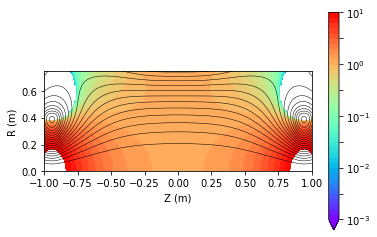

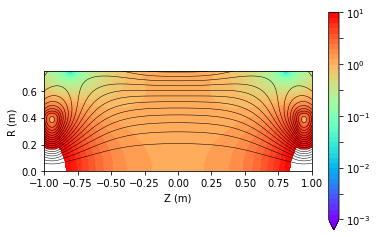

In [3]:
# get desired field quantities from brb object and view coilset
B = np.sqrt(wham.BR()**2 + wham.BZ()**2).reshape(R.shape)
BR = wham.BR().reshape(R.shape)
BZ = wham.BZ().reshape(R.shape)
psi = wham.psi().reshape(R.shape)
psi_lim = locs_to_vals(R, Z, psi, [(1.25, 0)])[0]
psi_space = np.linspace(0, psi_lim, 11)
bspace = np.logspace(-3, 1, 41)

# Plotting Section
fig, ax = plt.subplots()
cf = ax.contourf(Z, R, BZ, bspace, cmap="rainbow", locator=ticker.LogLocator(), extend='min')
ax.contour(Z, R, psi, 21, colors="k", linewidths=0.5)
fig.colorbar(cf)
ax.set_xlim(-1., 1.)
ax.set_ylim(0, 0.75)
ax.set_xlabel("Z (m)")
ax.set_ylabel("R (m)")
ax.set_aspect(1)
plt.show()

# Zoomed in Plotting Section
fig,ax = plt.subplots()
cf = ax.contourf(Z,R,B,bspace,cmap="rainbow",locator=ticker.LogLocator(), extend='min')
ax.contour(Z,R,psi,21,colors="k", linewidths=0.5)
fig.colorbar(cf)
ax.set_xlim(-1., 1.)
ax.set_ylim(0, 0.75)
ax.set_xlabel("Z (m)")
ax.set_ylabel("R (m)")
ax.set_aspect(1)
plt.show()

Now lets look at an equilibrium... A few parameters are important here: namely the plasma limiting radius, a, the peak pressure, P0, the exponent of the pressure profile, alpha, and the plasma beta at the origin with respect to the vacuum field. Once we build the pressure function and get the Green's function for plasma currents on the grid we are ready to run compute_equilibrium and write out an eqdsk. When this cell is run you should see the iteration number and error print to the screen and the error should decrease to a small value below 1E-10 by default to know the computation has converged.

In [4]:
# setup pressure profile and compute P0 for a given desired initial beta
a = .5
alpha = 2.0
beta0 = .1
B0 = locs_to_vals(R,Z,B,[(0,0)])[0]
P0 = beta0*B0**2/(2*4*np.pi*1E-7)
print("pressure ", P0)
# build pressure function of cylindrical radius
Pfunc = lambda x: P0*(1-(x/a)**2)**alpha if x < a else 0
# get greens function for plasma currents
gplas = get_gpsi(R,Z)
# compute equilibrium
psieq,plas_currents,pfit = compute_equilibrium(R,Z,Pfunc,psi,gplas,maxiter=400,plotit=False)
write_eqdsk(R,Z,psi,plas_currents,"wham_eqdsk.txt","WHAM_Mirror Equilib")
P = pfit(psi.flatten()).reshape(psi.shape)
jphi = plas_currents/((R[0,1]-R[0,0])*(Z[1,0]-Z[0,0]))

pressure  55831.54115016246
computing gpsi blocks...
creating reflected block matrix
building huge matrix...
returning...
0
1
1
0.8961154012763798
2
0.005589373519163506
3
0.00012944851537745114
4
2.9734097311246333e-06
5
2.7443691110110562e-08
6
2.657020365635984e-10
7
8.560402008105758e-12


Below we will plot some flux lines as well as the diamagnetic current density j_phi in A/m^2 in the colormap. We've also included a demonstration of tracing field lines which can be used to interpolate values along a field line for stability calculations as well as flux surface averaging.

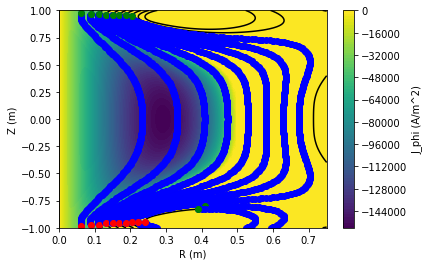

In [5]:
fig,ax = plt.subplots()
cf = ax.contourf(R,Z,jphi,101)
cs = ax.contour(R,Z,psieq,psi_space,colors="k")
for clev in psi_space[1:]:
    flpts = get_fieldlines(cs,clev,start_coord=(0.05,.98),end_coord=(0.05,-0.98),clockwise=True)
    ax.plot(flpts[:,0],flpts[:,1],"bo")
    ax.plot(flpts[0,0],flpts[0,1],"go")
    ax.plot(flpts[-1,0],flpts[-1,1],"ro")
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
cbar = fig.colorbar(cf)
cbar.set_label("J_phi (A/m^2)")
plt.show()

Here let's plot a slice of B along the axis of symmetry.

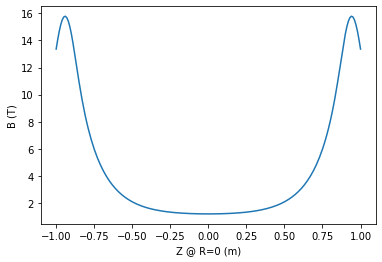

In [6]:
#### Plotting 
# plot slice of B as function of Z at R=0
ridx = np.abs(R[0,:]).argmin()
plt.plot(Z[:,ridx],B[:,ridx])
plt.xlabel("Z @ R=0 (m)")
plt.ylabel("B (T)")
plt.show()